In [1]:
#import packages
import pandas as pd
import requests
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request, json
import requests
import urllib.parse
import datetime
import nltk
nltk.download([
        "names",
        "stopwords",
        "averaged_perceptron_tagger",
        "vader_lexicon",
        "punkt",])

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package names to
[nltk_data]     /Users/lizjohnson/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lizjohnson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/lizjohnson/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lizjohnson/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lizjohnson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### NYC Open Data:
    
SODA API Urls:

* 311 Call Inquiries: `https://data.cityofnewyork.us/resource/wewp-mm3p.json`

 **Important Column Names:**

   * uniqueid = 'UNIQUE_ID'
   * cat_clnm = 'AGENCY_NAME'
   * subcat_clnm = 'INQUIRY_NAME'
   * subsubcat_clnm = 'BRIEF_DESCRIPTION'
   * datetime_clnm = 'DATE_TIME'


* 311 Web Inquiries: `https://data.cityofnewyork.us/resource/vwpc-kje2.json`

 **Important Column Names:**

   * uniqueid = 'simple_id'
   * cat_clnm = 'service_name'
   * subcat_clnm = 'brief_description'
   * subsubcat_clnm = 'detailed_description'
   * datetime_clnm = 'updated_date'

In [12]:
def get_data(url, uniqueid, startdatetime, enddatetime, cat_clnm, subcat_clnm, subsubcat_clnm, datetime_clnm):
    '''
    Inputs: 
    url - string value of SODA API url
    startdatetime & enddatetime - string values of the format 'YYYY-MM-DDTHH:MM:SS', i.e. '2019-12-31T23:59:59.000' 
                                for the beginning and end of timeframe of interest
    datetime_clnm - string value of the column name in the data for the datetime of complaint inquiry
    
    Output:
    gdf - GeoDataFrame of 311 inquiries. Geometry is point location of 311 inquiry.
    '''
    query = (url +'?'
            "$select= count(*) as count,%s as cat, %s as subcat, %s as subsubcat"
            "&$where=%s between '"+startdatetime+"' and '"+enddatetime+"'"
            "&$group=cat,subcat,subsubcat"
            "&$order=count DESC"
            "&$limit=500000"
            )%(cat_clnm,subcat_clnm,subsubcat_clnm,datetime_clnm)
    query = query.replace(" ", "%20")
    print(query)
    response = urllib.request.urlopen(query)
    data = json.loads(response.read())

#     for d in data:
#         d['geometry'] = shape(d['the_geom'])

#     #store in a geodataframe
#     gdf = gpd.GeoDataFrame(data, geometry = 'geometry', crs = 'EPSG: 4326')
#     gdf = gdf.drop(columns = ['the_geom'])
    
    return data

In [13]:
all311 = 'https://data.cityofnewyork.us/resource/erm2-nwe9.json'
uniqueid = 'unique_key'
cat_clnm = 'agency_name'
subcat_clnm = 'complaint_type'
subsubcat_clnm = 'descriptor'
datetime_clnm = 'created_date'

data = get_data(all311, uniqueid, '2019-01-01T00:00:00.000', '2020-01-01T00:00:00.000', cat_clnm, subcat_clnm, subsubcat_clnm, datetime_clnm)

https://data.cityofnewyork.us/resource/erm2-nwe9.json?$select=%20count(*)%20as%20count,agency_name%20as%20cat,%20complaint_type%20as%20subcat,%20descriptor%20as%20subsubcat&$where=created_date%20between%20'2019-01-01T00:00:00.000'%20and%20'2019-02-01T00:00:00.000'&$group=cat,subcat,subsubcat&$order=count%20DESC&$limit=500000


In [14]:
all_df = pd.DataFrame(data, columns = data[0].keys())
all_df.head()

,count,cat,subcat,subsubcat
0,28289,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING
1,18810,Department of Housing Preservation and Develop...,HEAT/HOT WATER,APARTMENT ONLY
2,14628,Department of Sanitation,Request Large Bulky Item Collection,Request Large Bulky Item Collection
3,8822,New York City Police Department,Noise - Residential,Loud Music/Party
4,8278,New York City Police Department,Blocked Driveway,No Access


In [15]:
len(all_df)

1175

In [17]:
len(all_df[all_df['cat'].isna()])

0

In [18]:
all_df['combined_cats'] = all_df['cat'].fillna('') \
                      .str.cat(all_df['subcat'].fillna(''), sep=' ') \
                      .str.cat(all_df['subsubcat'].fillna(''), sep=' ')

all_df.head()

,count,cat,subcat,subsubcat,combined_cats
0,28289,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,Department of Housing Preservation and Develop...
1,18810,Department of Housing Preservation and Develop...,HEAT/HOT WATER,APARTMENT ONLY,Department of Housing Preservation and Develop...
2,14628,Department of Sanitation,Request Large Bulky Item Collection,Request Large Bulky Item Collection,Department of Sanitation Request Large Bulky I...
3,8822,New York City Police Department,Noise - Residential,Loud Music/Party,New York City Police Department Noise - Reside...
4,8278,New York City Police Department,Blocked Driveway,No Access,New York City Police Department Blocked Drivew...


In [23]:
#clean combined_cats column to prepare for NLTK processing
#lowercase
all_df['combined_cats_lower'] = all_df['combined_cats'].str.lower()
#make list
txt_ls = all_df['combined_cats_lower'].tolist()

In [24]:
import re, string

tmp_list_unique = []

for item in txt_ls:
    
    item = item.replace('sanitation', 'sanitation waste')
    item = item.replace('parks', 'parks recreation')
    item = item.replace('recreation', 'parks recreation')
    item = item.replace('watr', 'water')
    item = item.replace('wats', 'water')
    item = item.replace('wrs', 'waste')
    
    item = item.replace('park maintenance', 'recreation and parks maintenance')
    item = item.replace('park rules', 'recreation and parks rules')
    item = item.replace('park equipment', 'recreation and parks equipment')
    item = item.replace('park lawn', 'recreation and parks lawn')
    item = item.replace('park programs', 'recreation and parks program')
    item = item.replace('park light', 'recreation and parks light')
    item = item.replace('park rangers', 'recreation and parks rangers')
    item = item.replace('park surface', 'recreation and parks surface')
    item = item.replace('rec and park', 'recreation and parks')
    
    item = item.replace('wildlife', 'wildlife animal')
    item = item.replace('pigeon', 'pigeon animal')
    item = item.replace('bats', 'bats animal')
    item = item.replace('dog', 'dog animal')
    item = item.replace('stray', 'stray animal')
    item = item.replace('coyote', 'coyote animal')
    item = item.replace('pot hole', 'pothole street')
    item = item.replace('sinkhole', 'sinkhole pothole street')
    
    item = item.replace('parking', 'parking vehicles')
    item = item.replace('bugs', 'public health bugs pest control')
    itme = item.replace('mosquitoes', 'public health mosquito pest control')
    itme = item.replace('mosquito', 'public health mosquito pest control')
    itme = item.replace('roaches', 'public health roaches pest control')
    item = item.replace('mice', 'public health rats rodent pest control')
    item = item.replace('rodent', 'public health rodent rats pest control')
    item = item.replace('dumping', 'dumping waste')
    item = item.replace('illdump', 'illegal dumping waste')
    item = item.replace('plmb', 'plumbming')
    item = item.replace('haz', 'hazard')
    item = item.replace('cons', 'construction')
    item = item.replace('prmt', 'permit')
    item = item.replace('cnflct', 'conflict')
    item = item.replace('insp', 'inspection')
    item = item.replace('litter', 'litter waste')
    item = item.replace('isd', '')
    item = item.replace('traum counseling', 'trauma counseling')
    item = item.replace('dirty', 'dirty unsanitary')
    item = item.replace('bldgmaint', 'building maintenance')
    item = item.replace('derelict', 'abandonded')
    item = item.replace('blighted', 'abandonded')
    item = item.replace('vacant', 'abandonded')
    item = item.replace('building code', 'inspection code enforcement violation')
    item = item.replace('inspection', 'inspection code enforcement violation')
    item = item.replace('code enforcement', 'inspection code enforcement violation')
    item = item.replace('code violations', 'inspection code enforcement violation')
    item = item.replace('housing violations', 'inspection code enforcement violation')
    item = item.replace('property violations', 'inspection code enforcement violation')
    item = item.replace('codes compliance', 'inspection code enforcement violation')
    item = item.replace('transit', 'transit transportation')
    item = item.replace('transportation', 'transit transportation')
    item = item.replace('tenant', 'tenant housing rental')
    item = item.replace('rental issues', 'tenant housing rental')
    item = item.replace('brush', 'brush debris bulky')
    item = item.replace('loose leaf', 'brush debris bulky')
    item = item.replace('debris', 'brush debris bulky')
    item = item.replace('stlight(s)', 'street light')
    item = item.replace('collectn', 'bulky waste collection')
    item = item.replace('household appliances', 'bulky waste collection')
    item = item.replace('special collections', 'bulky waste collection')
    item = item.replace('property maintenance', 'property maintenance building residential')
    item = item.replace('building residential', 'property maintenance building residential')
    item = item.replace('forestry', 'tree')
    item = item.replace('national grid', 'electricity gas')
    item = item.replace('bicycle', 'bike')
    item = item.replace('botanical', 'tree')
    item = item.replace('property', 'property building')
    item = item.replace('pay station', 'pay station parking meter')
    item = item.replace('general inquiry', 'general information')
    item = item.replace('question', 'general information')
    item = item.replace('general questions', 'general information')
    item = item.replace('general request', 'general information')
    item = item.replace('literature request', 'general information')
    item = item.replace('program information', 'general information')
    item = item.replace('information request', 'general information')
    item = item.replace('records request', 'general information')
    
    item = item.replace('manhole', 'manhole drain')
    item = item.replace('missed collection', 'missed collection waste')
    item = item.replace('roadway', 'roads')
    
    item = item.replace('tax - ', 'tax taxpayer treasury')
    item = item.replace('compliment', 'commendation')
    
    item = item.replace('constructiontruction', 'construction')
    item = item.replace('contructionumber', 'construction')

    for number in ['1','2','3','4','5','6','7','8','9','0']:    
        item = item.replace(number,'')
    
    #remove symbols exc NEW CODE INSERTED BY LIZ JOHNSON 11/15/22
    item = np.char.replace(item, '/', ' ')
    symbols = "!\"\'#$%&()*+-./:;<=>?@[]^_`{|}~\n"
    for i in symbols:
        item = np.char.replace(item, i, '')
    
    tmp_list_unique.append(str(item).strip())

In [25]:
print(tmp_list_unique[0:10])

['department of housing preservation and development heat hot water entire building', 'department of housing preservation and development heat hot water apartment only', 'department of sanitation waste request large bulky item collection request large bulky item collection', 'new york city police department noise  residential loud music party', 'new york city police department blocked driveway no access', 'new york city police department noise  residential banging pounding', 'department of transit transportation street condition pothole', 'department of transit transportation street light condition street light out', 'new york city police department illegal parking vehicles blocked hydrant', 'department of sanitation waste electronics waste appointment ewaste appointment']


In [26]:
stopwords = nltk.corpus.stopwords.words('english')
#remove stopwords
tmp_list_unique = [[word for word in sentence.split() if word.lower() not in stopwords] for sentence in tmp_list_unique]
#join split sentences back
tmp_list_unique = [" ".join(split_sentence) for split_sentence in tmp_list_unique]

In [27]:
print(tmp_list_unique[0:10])

['department housing preservation development heat hot water entire building', 'department housing preservation development heat hot water apartment', 'department sanitation waste request large bulky item collection request large bulky item collection', 'new york city police department noise residential loud music party', 'new york city police department blocked driveway access', 'new york city police department noise residential banging pounding', 'department transit transportation street condition pothole', 'department transit transportation street light condition street light', 'new york city police department illegal parking vehicles blocked hydrant', 'department sanitation waste electronics waste appointment ewaste appointment']


In [28]:
all_df['processed_comps'] = tmp_list_unique

In [29]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define a function to calculate sentiment scores for each row in the dataframe
def get_sentiment_scores(row):
    # Use the VADER sentiment analyzer to get a sentiment score for the combined categories text
    sentiment_scores = analyzer.polarity_scores(row['processed_comps'])
    # Return the sentiment score dictionary
    return sentiment_scores

# Apply the function to each row in the dataframe and store the results in a new column
all_df['sentiment_scores'] = all_df.apply(get_sentiment_scores, axis=1)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lizjohnson/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [30]:
all_df.head()

,count,cat,subcat,subsubcat,combined_cats,combined_cats_lower,processed_comps,sentiment_scores
0,28289,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,Department of Housing Preservation and Develop...,department of housing preservation and develop...,department housing preservation development he...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,18810,Department of Housing Preservation and Develop...,HEAT/HOT WATER,APARTMENT ONLY,Department of Housing Preservation and Develop...,department of housing preservation and develop...,department housing preservation development he...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,14628,Department of Sanitation,Request Large Bulky Item Collection,Request Large Bulky Item Collection,Department of Sanitation Request Large Bulky I...,department of sanitation request large bulky i...,department sanitation waste request large bulk...,"{'neg': 0.189, 'neu': 0.811, 'pos': 0.0, 'comp..."
3,8822,New York City Police Department,Noise - Residential,Loud Music/Party,New York City Police Department Noise - Reside...,new york city police department noise - reside...,new york city police department noise resident...,"{'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'comp..."
4,8278,New York City Police Department,Blocked Driveway,No Access,New York City Police Department Blocked Drivew...,new york city police department blocked drivew...,new york city police department blocked drivew...,"{'neg': 0.231, 'neu': 0.769, 'pos': 0.0, 'comp..."


In [31]:
all_df[['neg','neu', 'pos', 'compound']] = all_df['sentiment_scores'].apply(pd.Series)
all_df.head()

,count,cat,subcat,subsubcat,combined_cats,combined_cats_lower,processed_comps,sentiment_scores,neg,neu,pos,compound
0,28289,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,Department of Housing Preservation and Develop...,department of housing preservation and develop...,department housing preservation development he...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
1,18810,Department of Housing Preservation and Develop...,HEAT/HOT WATER,APARTMENT ONLY,Department of Housing Preservation and Develop...,department of housing preservation and develop...,department housing preservation development he...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
2,14628,Department of Sanitation,Request Large Bulky Item Collection,Request Large Bulky Item Collection,Department of Sanitation Request Large Bulky I...,department of sanitation request large bulky i...,department sanitation waste request large bulk...,"{'neg': 0.189, 'neu': 0.811, 'pos': 0.0, 'comp...",0.189,0.811,0.000,-0.4215
3,8822,New York City Police Department,Noise - Residential,Loud Music/Party,New York City Police Department Noise - Reside...,new york city police department noise - reside...,new york city police department noise resident...,"{'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'comp...",0.000,0.769,0.231,0.4019
4,8278,New York City Police Department,Blocked Driveway,No Access,New York City Police Department Blocked Drivew...,new york city police department blocked drivew...,new york city police department blocked drivew...,"{'neg': 0.231, 'neu': 0.769, 'pos': 0.0, 'comp...",0.231,0.769,0.000,-0.2732


In [32]:
# Calculate the mean compound sentiment score for each category
mean_sentiment_scores = all_df.groupby('combined_cats')['sentiment_scores'].apply(lambda x: x.apply(lambda y: y['compound']).mean())

In [33]:
#save outputs
all_df.to_csv('../Outputs/311calls_complaints_vadar_results_geolocation311.csv')

### Let's try and visualize the 311 inquiries' sentiment analysis results...

# RESTART FROM HERE

In [34]:
all_df = pd.read_csv('../Outputs/311calls_complaints_vadar_results_geolocation311.csv', index_col = 0)
all_df.head()

,count,cat,subcat,subsubcat,combined_cats,combined_cats_lower,processed_comps,sentiment_scores,neg,neu,pos,compound
0,28289,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,Department of Housing Preservation and Develop...,department of housing preservation and develop...,department housing preservation development he...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
1,18810,Department of Housing Preservation and Develop...,HEAT/HOT WATER,APARTMENT ONLY,Department of Housing Preservation and Develop...,department of housing preservation and develop...,department housing preservation development he...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
2,14628,Department of Sanitation,Request Large Bulky Item Collection,Request Large Bulky Item Collection,Department of Sanitation Request Large Bulky I...,department of sanitation request large bulky i...,department sanitation waste request large bulk...,"{'neg': 0.189, 'neu': 0.811, 'pos': 0.0, 'comp...",0.189,0.811,0.000,-0.4215
3,8822,New York City Police Department,Noise - Residential,Loud Music/Party,New York City Police Department Noise - Reside...,new york city police department noise - reside...,new york city police department noise resident...,"{'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'comp...",0.000,0.769,0.231,0.4019
4,8278,New York City Police Department,Blocked Driveway,No Access,New York City Police Department Blocked Drivew...,new york city police department blocked drivew...,new york city police department blocked drivew...,"{'neg': 0.231, 'neu': 0.769, 'pos': 0.0, 'comp...",0.231,0.769,0.000,-0.2732


In [35]:
mean_values = all_df[['cat','neg','neu','pos', 'compound']].groupby('cat').agg({'neg': 'mean', 'neu': 'mean', 'pos': 'mean', 'compound': 'mean'})
median_values = all_df[['cat','neg','neu','pos', 'compound']].groupby('cat').agg({'neg': 'median', 'neu': 'median', 'pos': 'median', 'compound': 'median'})

In [36]:
mean_values.sort_values(by = 'compound', ascending = False).head(10)

,neg,neu,pos,compound
cat,,,,
HRA Benefit Card Replacement,0.000,0.519000,0.481000,0.718400
School - Fannie Lou Hamer Freedom High School,0.170,0.566000,0.264000,0.361200
Disability Rent Increase Exemption Unit,0.000,0.733250,0.266750,0.360887
Senior Citizen Rent Increase Exemption Unit,0.000,0.757750,0.242250,0.360887
Valuation Policy,0.164,0.545000,0.291000,0.273200
School - Success Academy Union Square Manhattan 1,0.188,0.556000,0.257000,0.250000
HealthCare Connections,0.039,0.751167,0.209833,0.190967
School - High School for Public Service: Heroes of Tomorrow,0.180,0.600000,0.220000,0.153100
Payment Operations,0.071,0.781667,0.147333,0.153000


In [37]:
median_values.sort_values(by = 'compound', ascending = False).head(10)

,neg,neu,pos,compound
cat,,,,
HRA Benefit Card Replacement,0.000,0.5190,0.4810,0.7184
School - Fannie Lou Hamer Freedom High School,0.170,0.5660,0.2640,0.3612
Senior Citizen Rent Increase Exemption Unit,0.000,0.7770,0.2230,0.3182
Disability Rent Increase Exemption Unit,0.000,0.7530,0.2470,0.3182
Valuation Policy,0.164,0.5450,0.2910,0.2732
School - Success Academy Union Square Manhattan 1,0.188,0.5560,0.2570,0.2500
School - High School for Public Service: Heroes of Tomorrow,0.180,0.6000,0.2200,0.1531
HealthCare Connections,0.000,0.7985,0.1700,0.1250
School - FDNY Captain Vernon A Richard High School for Fire and Life Safety,0.140,0.6980,0.1630,0.1027


In [38]:
mean_values.sort_values(by = 'compound').head(10)

,neg,neu,pos,compound
cat,,,,
School - PS-MS 20 PO George J Werdann III,0.441000,0.559000,0.00000,-0.743000
Department of Sanitation,0.430473,0.562797,0.00673,-0.607564
Traffic Management Center,0.265000,0.735000,0.00000,-0.557400
School - John Jay School for Law,0.256000,0.744000,0.00000,-0.476700
School - PS 219 Kennedy-King,0.307000,0.693000,0.00000,-0.476700
Department of Information Technology and Telecommunications,0.310286,0.689714,0.00000,-0.465700
School - PS 107 Thomas A Dooley,0.278000,0.722000,0.00000,-0.401900
School - PS 105 Senator Abraham Bernstein,0.231000,0.769000,0.00000,-0.401900
School - Norma Adams Clemons Academy,0.252000,0.748000,0.00000,-0.401900


In [39]:
median_values.sort_values(by = 'compound').head(10)

,neg,neu,pos,compound
cat,,,,
School - PS-MS 20 PO George J Werdann III,0.4410,0.5590,0.0,-0.7430
Department of Sanitation,0.4120,0.5720,0.0,-0.6808
Department of Information Technology and Telecommunications,0.3570,0.6430,0.0,-0.5859
Traffic Management Center,0.2650,0.7350,0.0,-0.5574
Taxi and Limousine Commission,0.3705,0.6295,0.0,-0.5267
School - PS 219 Kennedy-King,0.3070,0.6930,0.0,-0.4767
School - John Jay School for Law,0.2560,0.7440,0.0,-0.4767
Department of Parks and Recreation,0.2240,0.7760,0.0,-0.4404
School - Long Island City High School,0.2310,0.7690,0.0,-0.4019


In [40]:
top_5_pos = list(mean_values.sort_values(by='compound', ascending=False)['compound'].head(5).index)
top_5_neg = list(mean_values.sort_values(by='compound', ascending=False)['compound'].tail(5).index)
print(top_5_pos,top_5_neg)

['HRA Benefit Card Replacement', 'School - Fannie Lou Hamer Freedom High School', 'Disability Rent Increase Exemption Unit', 'Senior Citizen Rent Increase Exemption Unit', 'Valuation Policy'] ['School - PS 219 Kennedy-King', 'School - John Jay School for Law', 'Traffic Management Center', 'Department of Sanitation', 'School - PS-MS 20 PO George J Werdann III']


In [41]:
len(all_df[all_df['cat'] == top_5_neg[-1]])

1

In [42]:
all_df[all_df['cat'] == top_5_neg[-1]].sort_values(by = 'compound')

,count,cat,subcat,subsubcat,combined_cats,combined_cats_lower,processed_comps,sentiment_scores,neg,neu,pos,compound
841,2,School - PS-MS 20 PO George J Werdann III,School Maintenance,Heating Problem,School - PS-MS 20 PO George J Werdann III Scho...,school - ps-ms 20 po george j werdann iii scho...,school psms po george j werdann iii school mai...,"{'neg': 0.441, 'neu': 0.559, 'pos': 0.0, 'comp...",0.441,0.559,0.0,-0.743


In [43]:
len(all_df[all_df['cat'].isin(top_5_pos[0:2])])

3

In [44]:
all_df[all_df['cat'].isin(top_5_pos[0:2])].sort_values(by = 'compound', ascending = False)

,count,cat,subcat,subsubcat,combined_cats,combined_cats_lower,processed_comps,sentiment_scores,neg,neu,pos,compound
44,961,HRA Benefit Card Replacement,Benefit Card Replacement,Medicaid,HRA Benefit Card Replacement Benefit Card Repl...,hra benefit card replacement benefit card repl...,hra benefit card replacement benefit card repl...,"{'neg': 0.0, 'neu': 0.5, 'pos': 0.5, 'compound...",0.00,0.500,0.500,0.7184
334,51,HRA Benefit Card Replacement,Benefit Card Replacement,Food Stamp,HRA Benefit Card Replacement Benefit Card Repl...,hra benefit card replacement benefit card repl...,hra benefit card replacement benefit card repl...,"{'neg': 0.0, 'neu': 0.538, 'pos': 0.462, 'comp...",0.00,0.538,0.462,0.7184
974,1,School - Fannie Lou Hamer Freedom High School,School Maintenance,Heating Problem,School - Fannie Lou Hamer Freedom High School ...,school - fannie lou hamer freedom high school ...,school fannie lou hamer freedom high school sc...,"{'neg': 0.17, 'neu': 0.566, 'pos': 0.264, 'com...",0.17,0.566,0.264,0.3612


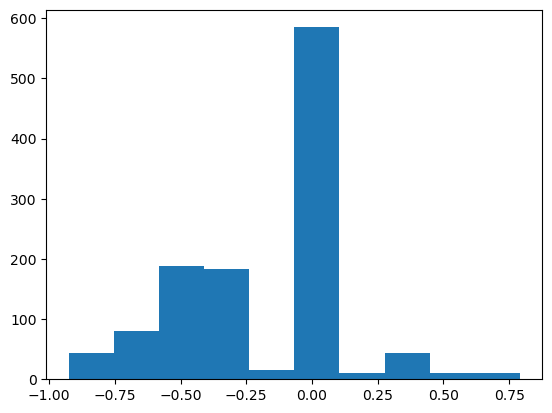

In [45]:
plt.hist(all_df['compound'])
plt.show()

In [46]:
#ten most positive complaints
pos_10 = all_df.sort_values(by='compound', ascending=False).head(10)
#ten most negative complaints
neg_10 = all_df.sort_values(by='compound', ascending=False).tail(10)

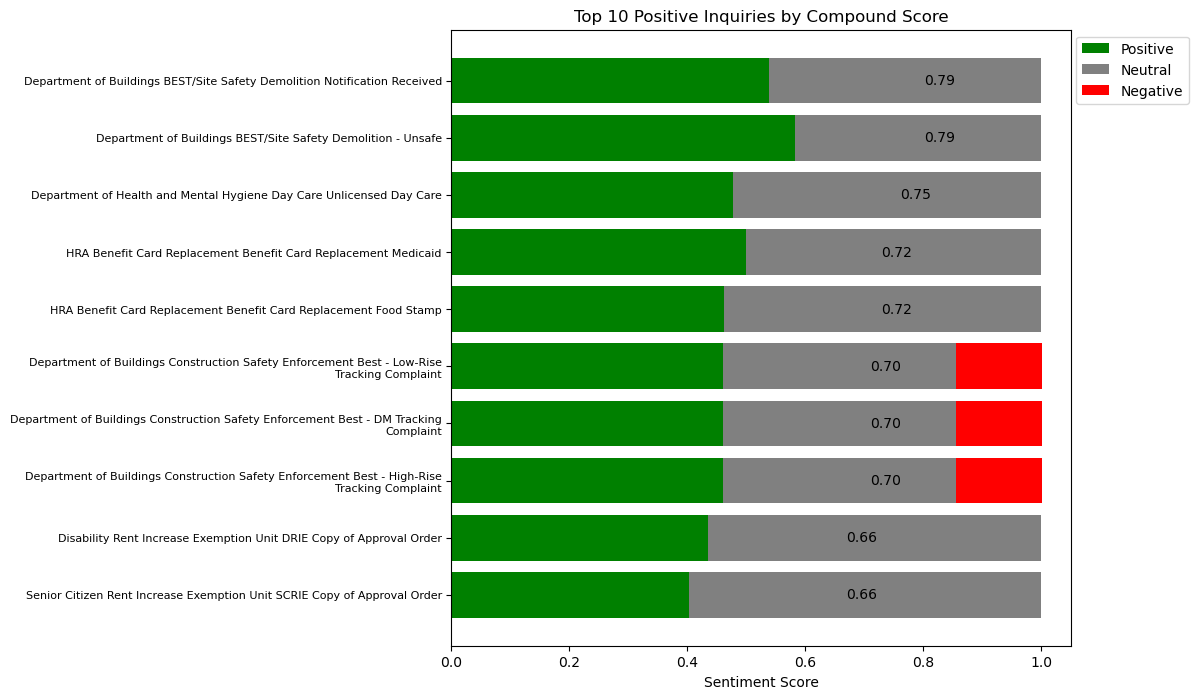

In [47]:
import textwrap

neg_scores = pos_10['neg'][::-1]
neu_scores = pos_10['neu'][::-1]
pos_scores = pos_10['pos'][::-1]
comps_scores = pos_10['compound'][::-1]

fig, ax = plt.subplots(figsize = (8,8))
ax.barh(np.arange(10), pos_scores, label='Positive', color='green')
ax.barh(np.arange(10), neu_scores, left=pos_scores, label='Neutral', color='gray')
ax.barh(np.arange(10), neg_scores, left=pos_scores+neu_scores, label='Negative', color='red')
ax.set_xlabel('Sentiment Score')
ax.set_title('Top 10 Positive Inquiries by Compound Score')
ax.set_yticks(np.arange(10))
# Wrap the text of each y-tick label onto multiple lines
wrapped_labels = [textwrap.fill(label, width=75) for label in pos_10['combined_cats'][::-1]]
ax.set_yticklabels(wrapped_labels, fontsize = 8)
# Add label on top of each bar
for i, score in enumerate(comps_scores):
    ax.text(score+0.01, i, f'{score:.2f}', ha='left', va='center')
legend = ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.savefig('../Outputs/Top_10_Positive_Compound_barh.png', bbox_inches='tight')
plt.show()

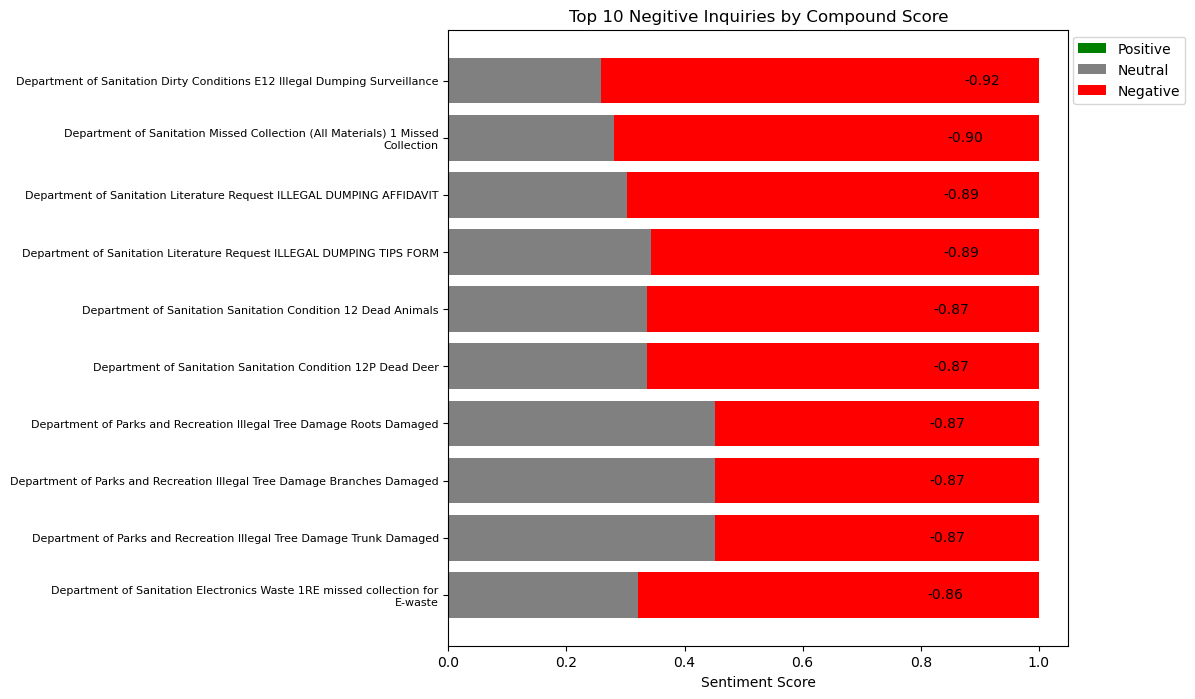

In [48]:
neg_scores = neg_10['neg']
neu_scores = neg_10['neu']
pos_scores = neg_10['pos']
comps_scores = neg_10['compound']

fig, ax = plt.subplots(figsize = (8,8))
ax.barh(np.arange(10), pos_scores, label='Positive', color='green')
ax.barh(np.arange(10), neu_scores, left=pos_scores, label='Neutral', color='gray')
ax.barh(np.arange(10), neg_scores, left=pos_scores+neu_scores, label='Negative', color='red')
ax.set_xlabel('Sentiment Score')
ax.set_title('Top 10 Negitive Inquiries by Compound Score')
ax.set_yticks(np.arange(10))
# Wrap the text of each y-tick label onto multiple lines
wrapped_labels = [textwrap.fill(label, width=75) for label in neg_10['combined_cats']]
ax.set_yticklabels(wrapped_labels, fontsize = 8)
# Add label on top of each bar
for i, score in enumerate(comps_scores):
    ax.text(abs(score)+0.01, i, f'{score:.2f}', ha='right', va='center')
legend = ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.savefig('../Outputs/Top_10_Negative_Compound_barh.png', bbox_inches='tight')
plt.show()

In [49]:
#look into neutrals
len(all_df[all_df['compound'] == 0])

564

In [50]:
len(all_df[all_df['compound'] != 0])

611

In [51]:
neu = all_df[all_df['compound'] == 0]
neu['cat'].value_counts()

Department of Transportation                              119
Department of Health and Mental Hygiene                    67
Department of Housing Preservation and Development         56
Department of Environmental Protection                     51
New York City Police Department                            32
                                                         ... 
School - Bronx Academy for Software Engineering (BASE)      1
School - PS 20 Port Richmond                                1
School - PS 333 Manhattan School for Children               1
School - PS-IS 30 Mary White Ovington                       1
School - PS 63 Old South                                    1
Name: cat, Length: 105, dtype: int64

In [52]:
neu.head(15)

,count,cat,subcat,subsubcat,combined_cats,combined_cats_lower,processed_comps,sentiment_scores,neg,neu,pos,compound
0,28289,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,Department of Housing Preservation and Develop...,department of housing preservation and develop...,department housing preservation development he...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.0,0.0,0.0
1,18810,Department of Housing Preservation and Develop...,HEAT/HOT WATER,APARTMENT ONLY,Department of Housing Preservation and Develop...,department of housing preservation and develop...,department housing preservation development he...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.0,0.0,0.0
5,5850,New York City Police Department,Noise - Residential,Banging/Pounding,New York City Police Department Noise - Reside...,new york city police department noise - reside...,new york city police department noise resident...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.0,0.0,0.0
6,5198,Department of Transportation,Street Condition,Pothole,Department of Transportation Street Condition ...,department of transportation street condition ...,department transit transportation street condi...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.0,0.0,0.0
7,4386,Department of Transportation,Street Light Condition,Street Light Out,Department of Transportation Street Light Cond...,department of transportation street light cond...,department transit transportation street light...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.0,0.0,0.0
10,3327,New York City Police Department,Derelict Vehicle,With License Plate,New York City Police Department Derelict Vehic...,new york city police department derelict vehic...,new york city police department abandonded veh...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.0,0.0,0.0
11,3242,Department of Housing Preservation and Develop...,UNSANITARY CONDITION,PESTS,Department of Housing Preservation and Develop...,department of housing preservation and develop...,department housing preservation development un...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.0,0.0,0.0
16,2779,Department of Housing Preservation and Develop...,UNSANITARY CONDITION,MOLD,Department of Housing Preservation and Develop...,department of housing preservation and develop...,department housing preservation development un...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.0,0.0,0.0
17,2609,Department of Housing Preservation and Develop...,PAINT/PLASTER,CEILING,Department of Housing Preservation and Develop...,department of housing preservation and develop...,department housing preservation development pa...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.0,0.0,0.0
18,2534,Department of Housing Preservation and Develop...,PAINT/PLASTER,WALL,Department of Housing Preservation and Develop...,department of housing preservation and develop...,department housing preservation development pa...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.0,0.0,0.0


In [53]:
len(neu[neu['neu'] != 1])

1

In [54]:
all_df[all_df['combined_cats_lower'].str.contains('homeless')].sort_values(by = 'compound').head(15)

,count,cat,subcat,subsubcat,combined_cats,combined_cats_lower,processed_comps,sentiment_scores,neg,neu,pos,compound
737,4,Department of Transportation,Ferry Complaint,Homeless Issue,Department of Transportation Ferry Complaint H...,department of transportation ferry complaint h...,department transit transportation ferry compla...,"{'neg': 0.268, 'neu': 0.732, 'pos': 0.0, 'comp...",0.268,0.732,0.0,-0.296
43,1018,Department of Homeless Services,Homeless Person Assistance,NaN,Department of Homeless Services Homeless Perso...,department of homeless services homeless perso...,department homeless services homeless person a...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.0,0.000
188,158,New York City Police Department,Homeless Encampment,NaN,New York City Police Department Homeless Encam...,new york city police department homeless encam...,new york city police department homeless encam...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.0,0.000
438,23,Department of Homeless Services,Homeless Person Assistance,NaN,Department of Homeless Services Homeless Perso...,department of homeless services homeless perso...,department homeless services homeless person a...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.0,0.000
754,3,Operations Unit - Department of Homeless Services,Homeless Person Assistance,NaN,Operations Unit - Department of Homeless Servi...,operations unit - department of homeless servi...,operations unit department homeless services h...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.0,0.000


In [55]:
all_df[all_df['combined_cats_lower'].str.contains('noise')].sort_values(by = 'compound').head(15)

,count,cat,subcat,subsubcat,combined_cats,combined_cats_lower,processed_comps,sentiment_scores,neg,neu,pos,compound
197,147,Department of Environmental Protection,Sewer,Manhole Cover Broken/Making Noise (SB),Department of Environmental Protection Sewer M...,department of environmental protection sewer m...,department environmental protection sewer manh...,"{'neg': 0.237, 'neu': 0.763, 'pos': 0.0, 'comp...",0.237,0.763,0.0,-0.4767
349,42,Department of Sanitation,Collection Truck Noise,21 Collection Truck Noise,Department of Sanitation Collection Truck Nois...,department of sanitation collection truck nois...,department sanitation waste collection truck n...,"{'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'comp...",0.259,0.741,0.0,-0.4215
93,401,Department of Environmental Protection,Noise,Noise: Alarms (NR3),Department of Environmental Protection Noise N...,department of environmental protection noise n...,department environmental protection noise nois...,"{'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'comp...",0.259,0.741,0.0,-0.2732
206,135,Department of Environmental Protection,Noise,Noise: Private Carting Noise (NQ1),Department of Environmental Protection Noise N...,department of environmental protection noise n...,department environmental protection noise nois...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.0,0.0000
820,2,Department of Environmental Protection,Noise,Noise: Loud Music/Daytime (Mark Date And Time)...,Department of Environmental Protection Noise N...,department of environmental protection noise n...,department environmental protection noise nois...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.0,0.0000
309,58,New York City Police Department,Noise - Commercial,Car/Truck Horn,New York City Police Department Noise - Commer...,new york city police department noise - commer...,new york city police department noise commerci...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.0,0.0000
339,45,Economic Development Corporation,Noise - Helicopter,Other,Economic Development Corporation Noise - Helic...,economic development corporation noise - helic...,economic development corporation noise helicopter,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.0,0.0000
350,41,New York City Police Department,Noise - Commercial,Car/Truck Music,New York City Police Department Noise - Commer...,new york city police department noise - commer...,new york city police department noise commerci...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.0,0.0000
537,12,Department of Environmental Protection,Noise,Noise: Manufacturing Noise (NK1),Department of Environmental Protection Noise N...,department of environmental protection noise n...,department environmental protection noise nois...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.0,0.0000
572,11,Department of Environmental Protection,Noise,"Noise, Other Animals (NR6)",Department of Environmental Protection Noise N...,department of environmental protection noise n...,department environmental protection noise nois...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.0,0.0000


In [56]:
all_df[all_df['combined_cats_lower'].str.contains('graffiti')].sort_values(by = 'compound').head(15)

,count,cat,subcat,subsubcat,combined_cats,combined_cats_lower,processed_comps,sentiment_scores,neg,neu,pos,compound
734,4,Department of Transportation,Bus Stop Shelter Complaint,Dirty/Graffiti,Department of Transportation Bus Stop Shelter ...,department of transportation bus stop shelter ...,department transit transportation bus stop she...,"{'neg': 0.51, 'neu': 0.49, 'pos': 0.0, 'compou...",0.510,0.490,0.0,-0.7430
599,9,Department of Information Technology and Telec...,Public Payphone Complaint,Graffiti/Litter on Phone,Department of Information Technology and Telec...,department of information technology and telec...,department information technology telecommunic...,"{'neg': 0.357, 'neu': 0.643, 'pos': 0.0, 'comp...",0.357,0.643,0.0,-0.6124
644,7,Department of Transportation,Broken Parking Meter,Graffiti,Department of Transportation Broken Parking Me...,department of transportation broken parking me...,department transit transportation broken parki...,"{'neg': 0.307, 'neu': 0.693, 'pos': 0.0, 'comp...",0.307,0.693,0.0,-0.4767
773,3,Department of Transportation,Public Toilet,Dirty/Graffiti,Department of Transportation Public Toilet Dir...,department of transportation public toilet dir...,department transit transportation public toile...,"{'neg': 0.293, 'neu': 0.707, 'pos': 0.0, 'comp...",0.293,0.707,0.0,-0.4404
949,1,Department of Information Technology and Telec...,LinkNYC,Graffiti/Dirty Condition,Department of Information Technology and Telec...,department of information technology and telec...,department information technology telecommunic...,"{'neg': 0.266, 'neu': 0.734, 'pos': 0.0, 'comp...",0.266,0.734,0.0,-0.4404
15,2947,Department of Sanitation,Graffiti,Graffiti,Department of Sanitation Graffiti Graffiti,department of sanitation graffiti graffiti,department sanitation waste graffiti graffiti,"{'neg': 0.412, 'neu': 0.588, 'pos': 0.0, 'comp...",0.412,0.588,0.0,-0.4215
622,8,Department of Sanitation,Literature Request,GRAFFITI WAIVER,Department of Sanitation Literature Request GR...,department of sanitation literature request gr...,department sanitation waste general informatio...,"{'neg': 0.318, 'neu': 0.682, 'pos': 0.0, 'comp...",0.318,0.682,0.0,-0.4215
363,38,Department of Transportation,Highway Condition,Graffiti - Highway,Department of Transportation Highway Condition...,department of transportation highway condition...,department transit transportation highway cond...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.0,0.0000
408,28,Department of Parks and Recreation,Maintenance or Facility,Graffiti or Vandalism,Department of Parks and Recreation Maintenance...,department of parks and recreation maintenance...,department parks parks recreation parks recrea...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.0,0.0000
579,10,New York City Police Department,Graffiti,Police Report Requested,New York City Police Department Graffiti Polic...,new york city police department graffiti polic...,new york city police department graffiti polic...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.0,0.0000


# Check overlapping Categories

In [57]:
call_df = pd.read_csv('../Outputs/311calls_complaints_vadar_results.csv', index_col = 0)
call_df.head()

,count,cat,subcat,subsubcat,combined_cats,combined_cats_lower,processed_comps,sentiment_scores,neg,neu,pos,compound
0,84545,Department of Finance,Parking Ticket Lookup - Ticket or Plate Number...,Status of a parking ticket. Must know ticket o...,Department of Finance Parking Ticket Lookup - ...,department of finance parking ticket lookup - ...,department finance parking vehicles ticket loo...,"{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'comp...",0.000,0.874,0.126,0.1531
1,76516,3-1-1 Call Center,Service Request Status - General,Status of most Service Requests filed with 311.,3-1-1 Call Center Service Request Status - Gen...,3-1-1 call center service request status - gen...,call center service request status general sta...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
2,60523,Department of Finance,Property Tax Account Assistance and Bill Infor...,Help with questions about the property tax bil...,Department of Finance Property Tax Account Ass...,department of finance property tax account ass...,department finance property building tax accou...,"{'neg': 0.0, 'neu': 0.876, 'pos': 0.124, 'comp...",0.000,0.876,0.124,0.4019
3,57674,NaN,Bulk Item Disposal,"Learn how to get rid of bulk items. Schedule, ...",Bulk Item Disposal Learn how to get rid of bu...,bulk item disposal learn how to get rid of bu...,bulk item disposal learn get rid bulk items sc...,"{'neg': 0.111, 'neu': 0.889, 'pos': 0.0, 'comp...",0.111,0.889,0.000,-0.2500
4,57213,NaN,Heat or Hot Water Complaint in a Residential B...,Report a problem with heat or hot water in a r...,Heat or Hot Water Complaint in a Residential ...,heat or hot water complaint in a residential ...,heat hot water complaint residential building ...,"{'neg': 0.308, 'neu': 0.692, 'pos': 0.0, 'comp...",0.308,0.692,0.000,-0.5994


In [62]:
overlapping = pd.merge(all_df,call_df,how = 'inner', on = 'subcat')
len(overlapping)

168

In [63]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import pandas as pd

# Define a function to calculate the string similarity
def string_similarity(s1, s2):
    return fuzz.token_set_ratio(s1, s2)

# Merge the dataframes based on the 'cat' column
merged_df = pd.merge(all_df,call_df, on='cat', how='left')

# Define a function to find the best match for each row in the 'call_df' dataframe
def find_best_match(row):
    subcats = all_df[all_df['cat'] == row['cat']]['subcat']
    best_match = process.extractOne(row['subcat'], subcats, scorer=string_similarity)
    if best_match[1] >= 80: # Set a threshold for the string similarity
        return all_df[(all_df['cat'] == row['cat']) & (all_df['subcat'] == best_match[0])]

# Apply the 'find_best_match' function to each row in the 'call_df' dataframe
matches = merged_df.apply(find_best_match, axis=1)

# Merge the matches with the 'call_df' dataframe
matched_df = pd.concat([call_df, matches], axis=1)

# Drop the rows that do not have any matches
matched_df = matched_df.dropna(subset=['subcat_y'])

# Rename the columns
matched_df = matched_df.rename(columns={'subcat_x': 'subcat_call', 'subcat_y': 'subcat_all'})

# View the matched dataframe
print(len(matched_df))
matched_df.head()

KeyError: 'subcat'

In [64]:
merged_df.head()

,count_x,cat,subcat_x,subsubcat_x,combined_cats_x,combined_cats_lower_x,processed_comps_x,sentiment_scores_x,neg_x,neu_x,...,subcat_y,subsubcat_y,combined_cats_y,combined_cats_lower_y,processed_comps_y,sentiment_scores_y,neg_y,neu_y,pos_y,compound_y
0,28289,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,Department of Housing Preservation and Develop...,department of housing preservation and develop...,department housing preservation development he...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.0,...,Apartment Maintenance Complaint,Report a maintenance problem inside an apartment.,Department of Housing Preservation and Develop...,department of housing preservation and develop...,department housing preservation development ap...,"{'neg': 0.329, 'neu': 0.671, 'pos': 0.0, 'comp...",0.329,0.671,0.0,-0.5994
1,28289,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,Department of Housing Preservation and Develop...,department of housing preservation and develop...,department housing preservation development he...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.0,...,Heat or Hot Water Complaint in Entire Resident...,Report inadequate heat in an apartment buildin...,Department of Housing Preservation and Develop...,department of housing preservation and develop...,department housing preservation development he...,"{'neg': 0.197, 'neu': 0.803, 'pos': 0.0, 'comp...",0.197,0.803,0.0,-0.5994
2,28289,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,Department of Housing Preservation and Develop...,department of housing preservation and develop...,department housing preservation development he...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.0,...,Heat or Hot Water Complaint in Apartment,Report inadequate heat in an apartment between...,Department of Housing Preservation and Develop...,department of housing preservation and develop...,department housing preservation development he...,"{'neg': 0.224, 'neu': 0.776, 'pos': 0.0, 'comp...",0.224,0.776,0.0,-0.5994
3,28289,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,Department of Housing Preservation and Develop...,department of housing preservation and develop...,department housing preservation development he...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.0,...,Residential Public Area Maintenance Complaint,Make a complaint about a maintenance problem i...,Department of Housing Preservation and Develop...,department of housing preservation and develop...,department housing preservation development re...,"{'neg': 0.336, 'neu': 0.664, 'pos': 0.0, 'comp...",0.336,0.664,0.0,-0.7269
4,28289,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,Department of Housing Preservation and Develop...,department of housing preservation and develop...,department housing preservation development he...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.0,...,Residential Building-Wide Maintenance Complaint,Make a complaint about a maintenance problem a...,Department of Housing Preservation and Develop...,department of housing preservation and develop...,department housing preservation development re...,"{'neg': 0.353, 'neu': 0.647, 'pos': 0.0, 'comp...",0.353,0.647,0.0,-0.7269


In [ ]:
import pandas as pd
from fuzzywuzzy import fuzz


# define a function to perform fuzzy matching
def fuzzy_match(row, column):
    # get the processed_comps value from the row
    value = row[column]

    # find the best match in the other dataframe
    best_match = call_df['processed_comps'].apply(lambda x: fuzz.token_sort_ratio(value, x)).idxmax()

    # return the index of the best match
    return best_match

# apply the fuzzy matching function to the all_df dataframe
all_df['match'] = all_df.apply(fuzzy_match, args=('processed_comps',), axis=1)

# join the two dataframes based on the 'match' column
merged_df = pd.merge(all_df, call_df, left_on='match', right_index=True)

# drop the 'match' column from the merged dataframe
merged_df.drop('match', axis=1, inplace=True)


In [68]:
from rapidfuzz import process, fuzz

# create a dictionary of processed_comps values from call_df
call_comps_dict = call_df['processed_comps'].to_dict()

# define a function to perform fuzzy matching
# def fuzzy_match(row, column):
#     # get the processed_comps value from the row
#     value = row[column]

#     # find the best match in the call_comps_dict
#     best_match, _ = process.extractOne(value, call_comps_dict.values(), scorer=fuzz.token_sort_ratio)

#     # return the index of the best match
#     return list(call_comps_dict.keys())[list(call_comps_dict.values()).index(best_match)]
def fuzzy_match(row, column):
    value = row[column]
    best_match = process.extractOne(value, call_comps_dict.values(), scorer=fuzz.token_sort_ratio)[0]
    return list(call_comps_dict.keys())[list(call_comps_dict.values()).index(best_match)]

# apply the fuzzy matching function to the all_df dataframe
all_df['match'] = all_df.apply(fuzzy_match, args=('processed_comps',), axis=1)

# join the two dataframes based on the 'match' column
merged_df = pd.merge(all_df, call_df, left_on='match', right_index=True)

# drop the 'match' column from the merged dataframe
merged_df.drop('match', axis=1, inplace=True)

In [69]:
merged_df.head()

,count_x,cat_x,subcat_x,subsubcat_x,combined_cats_x,combined_cats_lower_x,processed_comps_x,sentiment_scores_x,neg_x,neu_x,...,subcat_y,subsubcat_y,combined_cats_y,combined_cats_lower_y,processed_comps_y,sentiment_scores_y,neg_y,neu_y,pos_y,compound_y
0,28289,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,Department of Housing Preservation and Develop...,department of housing preservation and develop...,department housing preservation development he...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.0,...,Division Transfer,Hidden service for activity coding.,Department of Housing Preservation and Develop...,department of housing preservation and develop...,department housing preservation development di...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.0,0.0,0.0
27,1767,Department of Housing Preservation and Develop...,DOOR/WINDOW,WINDOW FRAME,Department of Housing Preservation and Develop...,department of housing preservation and develop...,department housing preservation development do...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.0,...,Division Transfer,Hidden service for activity coding.,Department of Housing Preservation and Develop...,department of housing preservation and develop...,department housing preservation development di...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.0,0.0,0.0
29,1665,Department of Housing Preservation and Develop...,DOOR/WINDOW,DOOR,Department of Housing Preservation and Develop...,department of housing preservation and develop...,department housing preservation development do...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.0,...,Division Transfer,Hidden service for activity coding.,Department of Housing Preservation and Develop...,department of housing preservation and develop...,department housing preservation development di...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.0,0.0,0.0
47,909,Department of Housing Preservation and Develop...,UNSANITARY CONDITION,GARBAGE/RECYCLING STORAGE,Department of Housing Preservation and Develop...,department of housing preservation and develop...,department housing preservation development un...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.0,...,Division Transfer,Hidden service for activity coding.,Department of Housing Preservation and Develop...,department of housing preservation and develop...,department housing preservation development di...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.0,0.0,0.0
62,666,Department of Housing Preservation and Develop...,GENERAL,COOKING GAS,Department of Housing Preservation and Develop...,department of housing preservation and develop...,department housing preservation development ge...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.0,...,Division Transfer,Hidden service for activity coding.,Department of Housing Preservation and Develop...,department of housing preservation and develop...,department housing preservation development di...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.0,0.0,0.0


In [70]:
len(merged_df)

1175

In [71]:
len(all_df)

1175

In [72]:
len(call_df)

6596

In [73]:
merged_df[['processed_comps_x','processed_comps_y']]

,processed_comps_x,processed_comps_y
0,department housing preservation development he...,department housing preservation development di...
27,department housing preservation development do...,department housing preservation development di...
29,department housing preservation development do...,department housing preservation development di...
47,department housing preservation development un...,department housing preservation development di...
62,department housing preservation development ge...,department housing preservation development di...
...,...,...
1152,department constructionumer affairs constructi...,department constructionumer affairs car rental...
1160,department constructionumer affairs dca doh ne...,department constructionumer affairs cabaret li...
1162,department sanitation waste general informatio...,department sanitation waste illegal dumping wa...
1166,school high school public service heroes tomor...,service schools learn service programs new yor...


In [77]:
# Set the maximum column width to 50 to wrap the text onto multiple lines
pd.set_option('display.max_colwidth', -1)

# Display the 'processed_comps_x' and 'processed_comps_y' columns of the merged dataframe
merged_df[['processed_comps_x', 'processed_comps_y']].head(25)

,processed_comps_x,processed_comps_y
0,department housing preservation development heat hot water entire building,department housing preservation development division transfer hidden service activity coding
27,department housing preservation development door window window frame,department housing preservation development division transfer hidden service activity coding
29,department housing preservation development door window door,department housing preservation development division transfer hidden service activity coding
47,department housing preservation development unsanitary condition garbage recycling storage,department housing preservation development division transfer hidden service activity coding
62,department housing preservation development general cooking gas,department housing preservation development division transfer hidden service activity coding
117,department housing preservation development door window door frame,department housing preservation development division transfer hidden service activity coding
183,department housing preservation development safety fire escape,department housing preservation development division transfer hidden service activity coding
185,department housing preservation development general ventilation system,department housing preservation development division transfer hidden service activity coding
611,department housing preservation development outside building roof door hatch,department housing preservation development division transfer hidden service activity coding
649,department housing preservation development door window door dumbwaiter,department housing preservation development division transfer hidden service activity coding


In [4]:
#import packages
import pandas as pd
import geopandas as gpd
import requests
from shapely.geometry import shape, Point
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import urllib.request, json
import requests
import urllib.parse
import datetime
import os

import warnings
warnings.filterwarnings('ignore')

#import nta shapefile
nta_url = 'https://data.cityofnewyork.us/resource/q2z5-ai38.json'

query = (nta_url+'?'
        "$select=*"
        "&$limit=10000")
query = query.replace(" ", "%20")
response = urllib.request.urlopen(query)
data = json.loads(response.read())


for d in data:
    d['geometry'] = shape(d['the_geom'])

#store in a geodataframe
nta_gdf = gpd.GeoDataFrame(data, geometry = 'geometry', crs = 'EPSG: 4326')
nta_gdf = nta_gdf.drop(columns = ['the_geom'])
nta_gdf.head()

,boro_code,boro_name,county_fips,ntacode,ntaname,shape_leng,shape_area,geometry
0,4,Queens,081,QN08,St. Albans,45401.316803,77412747.847,"MULTIPOLYGON (((-73.75205 40.70523, -73.75174 ..."
1,2,Bronx,005,BX28,Van Cortlandt Village,21945.719299,25666124.5948,"MULTIPOLYGON (((-73.88705 40.88435, -73.88705 ..."
2,4,Queens,081,QN55,South Ozone Park,36708.1693055,82461393.7368,"MULTIPOLYGON (((-73.80577 40.68293, -73.80552 ..."
3,3,Brooklyn,047,BK40,Windsor Terrace,19033.6720656,14041667.99,"MULTIPOLYGON (((-73.98017 40.66115, -73.98021 ..."
4,3,Brooklyn,047,BK50,Canarsie,43703.6096661,82089678.6389,"MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ..."


In [5]:
len(nta_gdf)

195

In [6]:
195*12*13

30420

In [7]:
nta_gdf.ntacode.unique()

array(['QN08', 'BX28', 'QN55', 'BK40', 'BK50', 'BX41', 'QN26', 'BK68',
       'BK79', 'QN38', 'QN52', 'BK44', 'QN01', 'BX98', 'QN07', 'QN48',
       'BK77', 'BK41', 'BK75', 'QN33', 'QN44', 'MN06', 'BX07', 'QN62',
       'SI11', 'QN15', 'SI08', 'BX10', 'BX33', 'QN37', 'BX13', 'BK81',
       'BK85', 'QN35', 'SI37', 'QN23', 'QN12', 'QN46', 'QN50', 'BK91',
       'BK95', 'QN66', 'QN41', 'BK09', 'QN54', 'SI12', 'SI28', 'BX43',
       'BK64', 'BX55', 'QN47', 'QN49', 'BK63', 'SI14', 'BX06', 'BK21',
       'BK26', 'BX22', 'QN19', 'BK34', 'BX03', 'BX31', 'QN17', 'QN60',
       'BX29', 'BX30', 'BK27', 'BX05', 'QN22', 'QN51', 'QN02', 'QN76',
       'BX35', 'QN28', 'QN63', 'BK88', 'MN19', 'MN35', 'QN43', 'QN61',
       'MN04', 'MN50', 'BK58', 'BK96', 'MN20', 'BK90', 'BK73', 'BX59',
       'QN10', 'BK17', 'BX26', 'MN23', 'SI45', 'SI36', 'MN36', 'MN34',
       'MN27', 'MN21', 'MN31', 'MN40', 'MN22', 'MN33', 'BK33', 'BK61',
       'BK69', 'QN25', 'BK30', 'BK31', 'BX01', 'BX40', 'BX09', 'BX49',
      